!pip install yfinance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
import plotly.graph_objects as go
from tensorflow.keras.utils import plot_model

In [2]:
# Data Fetching
ticker = 'MARUTI.NS'
start_date = '2019-01-01'
end_date = end_date = datetime.today().strftime('%Y-%m-%d')
print(f"End date: {end_date}") 
df = yf.download(ticker, start=start_date, end=end_date)
if df.empty:
    print("Failed to fetch data. Please check the ticker symbol and date range.")
else:
    print(f"Data fetched for {ticker} from {start_date} to {end_date}")

End date: 2025-05-16
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data fetched for MARUTI.NS from 2019-01-01 to 2025-05-16


In [3]:
# Fetch NIFTY and SENSEX data
nifty = yf.download("^NSEI", start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'NIFTY_Close'})
sensex = yf.download("^BSESN", start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'SENSEX_Close'})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Merge with main stock dataframe
df = df.merge(nifty, left_index=True, right_index=True, how='inner')
df = df.merge(sensex, left_index=True, right_index=True, how='inner')

In [5]:
print(df['Close'].head())
print(df['Close'].isnull().sum())

Ticker        MARUTI.NS
Date                   
2019-01-02  6882.405762
2019-01-03  6821.895020
2019-01-04  6850.823730
2019-01-07  6971.608887
2019-01-08  7044.951660
Ticker
MARUTI.NS    0
dtype: int64


In [6]:
# Plot Stock Price History
fig=go.Figure()
#add traces
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df.index, y=df['Close'],
    mode='lines', name='Stock Prices',
    fill='tozeroy',
    line=dict(color='rgba(74,143,223,1)')
))

fig.update_layout(
    title='Stock Price Prediction',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    width=900,
    legend=dict(x=0, y=1),
    plot_bgcolor='rgba(19,27,43,0.0)',
    paper_bgcolor='rgba(19,27,43,0.0)',
    font=dict(color='rgba(105,123,147,255)'),
    hovermode="closest",
    yaxis=dict(
        spikecolor="rgba(105,123,149,255)",
        spikedash="solid",
        spikethickness=-2,
        tickformat=',',
        tickprefix='₹',
        gridcolor="rgba(105,123,147,0.4)",
        zeroline=False
    ),
    xaxis=dict(
        spikecolor="rgba(105,123,147,255)",
        spikedash="solid",
        spikethickness=-2,
        gridcolor="rgba(105,123,147,0.4)"
    )
)

fig.update_xaxes(showline=False, linewidth=0, linecolor='rgba(105,123,147,255)')
fig.show()

In [7]:
print(df.head())

Price             Close         High          Low         Open    Volume  \
Ticker        MARUTI.NS    MARUTI.NS    MARUTI.NS    MARUTI.NS MARUTI.NS   
Date                                                                       
2019-01-02  6882.405762  7064.365155  6859.820534  7050.160668    891844   
2019-01-03  6821.895020  6960.199201  6804.518103  6893.911590    715168   
2019-01-04  6850.823730  6921.372679  6781.411326  6855.085076    774445   
2019-01-07  6971.608887  7014.175181  6912.849848  6922.319505    687845   
2019-01-08  7044.951660  7059.440051  6933.777974  6988.607198    516841   

Price        NIFTY_Close  SENSEX_Close  
Ticker             ^NSEI        ^BSESN  
Date                                    
2019-01-02  10792.500000  35891.519531  
2019-01-03  10672.250000  35513.710938  
2019-01-04  10727.349609  35695.101562  
2019-01-07  10771.799805  35850.160156  
2019-01-08  10802.150391  35980.929688  


In [8]:
# Reorder Columns (Move "close to First Position")
col_close=df.pop('Close')
df.insert(0,'Close',col_close)

In [9]:
# 3. Select Necessary Columns
df = df[['Close', 'Open', 'High', 'Low', 'Volume', 'NIFTY_Close', 'SENSEX_Close']]

In [10]:
# 4. Normalize Data Using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = scaler.fit_transform(df)

In [11]:
# 5. Convert to NumPy Array
df_array = df_scaled.astype(np.float32)

In [12]:
# 6. Create Sequences for Time Series Forecasting
def create_sequences(data, seq_length=20):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

In [13]:
# Define Look-Back Period
seq_length = 20  # Use past 10 days to predict next day
sequences = create_sequences(df_array, seq_length + 1)

In [14]:
# 7. Split Data into Train (80%), Validation (10%), Test (10%)
def split_data(sequence):
    train_data, test_data = train_test_split(sequence, test_size=0.2, shuffle=False)
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)
    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(sequences)

In [15]:
# 8. Separate Features (X) and Target (y)
X_train, y_train = train_data[:, :-1, :], train_data[:, -1, 0]
X_valid, y_valid = val_data[:, :-1, :], val_data[:, -1, 0]
X_test, y_test = test_data[:, :-1, :], test_data[:, -1, 0]

print(f"x_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"x_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (1235, 20, 7), y_train shape: (1235,)
x_valid shape: (154, 20, 7), y_valid shape: (154,)
x_test shape: (155, 20, 7), y_test shape: (155,)


In [16]:
#model building
model = Sequential()
model.add(LSTM(units=80, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=35, return_sequences=False,kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(units=60))
model.add(Dropout(0.2))
model.add(Dense(units=60))
model.add(Dropout(0.2))
model.add(Dense(units=1))

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



#model building
model = Sequential()
model.add(LSTM(units=190, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(LSTM(units=80, return_sequences=False,activation='relu'))
model.add(Dense(units=60,activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(units=60,activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(units=1))

#model building best
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),activation='relu'))
model.add(LSTM(units=64, return_sequences=False,activation='relu'))#,kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(units=32,activation='relu'))
#model.add(Dropout(1))
#model.add(Dense(units=60))
#model.add(Dropout(0.2))
model.add(Dense(units=1))

In [17]:
#model building
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),activation='relu'))
model.add(LSTM(units=64, return_sequences=False,activation='relu'))#,kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(units=39,activation='relu'))
#model.add(Dense(units=3))
model.add(BatchNormalization())
#model.add(Dropout(1))
#model.add(Dense(units=60))
#model.add(Dropout(0.2))
model.add(Dense(units=1))

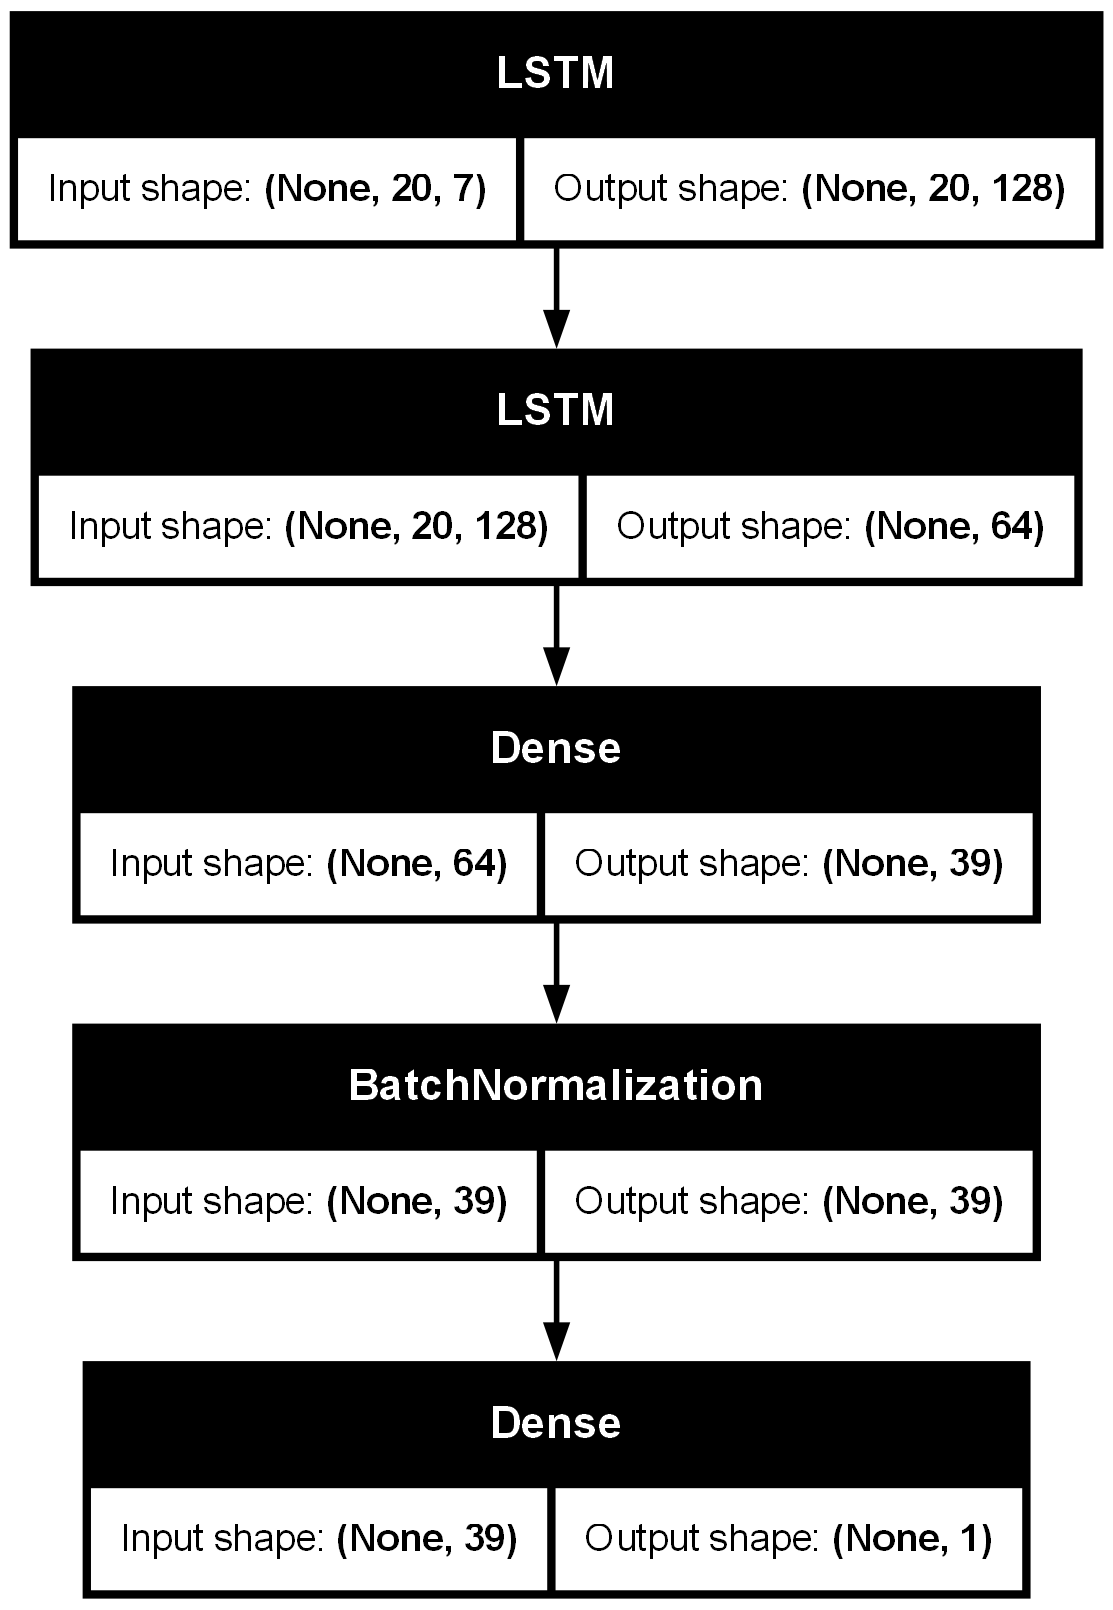

In [18]:
plot_model(model, show_shapes=True, to_file='model_architecture.png')

In [19]:
#model compilation
model.compile(optimizer='adam', loss='mse',metrics=['mean_squared_error'])

In [20]:
#Early stopping and model checkpoint
#early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=110, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras',monitor='val_loss', save_best_only=True)

In [21]:
#model Training
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_valid,y_valid),callbacks=[checkpoint],shuffle=False)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1734 - mean_squared_error: 0.1734 - val_loss: 0.8243 - val_mean_squared_error: 0.8243
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0939 - mean_squared_error: 0.0939 - val_loss: 0.9279 - val_mean_squared_error: 0.9279
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0845 - mean_squared_error: 0.0845 - val_loss: 0.9146 - val_mean_squared_error: 0.9146
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0839 - mean_squared_error: 0.0839 - val_loss: 0.9385 - val_mean_squared_error: 0.9385
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0825 - mean_squared_error: 0.0825 - val_loss: 0.9092 - val_mean_squared_error: 0.9092
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0823 - mean_squared_error: 0.0823 - val_loss: 0.7862 - val_mean_squared_error: 0.7862
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0820 - mean_squared_error: 0.0820 - val_loss: 0.74

In [22]:
# Predict and Reshape Results
predictions = model.predict(X_test)
predictions = predictions.reshape(-1, 1)

# Inverse Transform Predictions (Only Close Price)
predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((len(predictions), 6)))))[:, 0]

# Inverse Transform y_test (Only Close Price)
y_test_unscaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), 6)))))[:, 0]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [23]:
print(f"Shape of predictions: {predictions.shape}")
print(f"Shape of y_test_unscaled: {y_test_unscaled.shape}")

Shape of predictions: (155,)
Shape of y_test_unscaled: (155,)


In [24]:
#Evaluation metrics
predictions = predictions[-len(y_test_unscaled):]
rmse= np.sqrt(np.mean((predictions-y_test_unscaled)**2))
mae = mean_absolute_error(y_test_unscaled, predictions)
mse= mean_squared_error(y_test_unscaled, predictions)
r2= r2_score(y_test_unscaled, predictions)

In [25]:
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test MSE: {mse}")
print(f"Test R2: {r2}")

Test RMSE: 399.039420569571
Test MAE: 312.0072094924023
Test MSE: 159232.45916849896
Test R2: 0.6198158629108558


In [26]:
# Ensure train_size is defined correctly
train_size = int(len(df) * 0.9)

# Split into Train and Validation/Test Data
train = df.iloc[:train_size].copy()  # Training data
valid = df.iloc[train_size:].copy()  # Validation + Test data

# Ensure valid has the same length as predictions without skipping timestamps
valid = valid.iloc[-len(predictions):].copy()

In [27]:
#Add predictions to the validation data
valid['Predictions'] = predictions

In [28]:
print(train.columns)
print(valid.columns)

MultiIndex([(       'Close',          ''),
            (        'Open', 'MARUTI.NS'),
            (        'High', 'MARUTI.NS'),
            (         'Low', 'MARUTI.NS'),
            (      'Volume', 'MARUTI.NS'),
            ( 'NIFTY_Close',     '^NSEI'),
            ('SENSEX_Close',    '^BSESN')],
           names=['Price', 'Ticker'])
MultiIndex([(       'Close',          ''),
            (        'Open', 'MARUTI.NS'),
            (        'High', 'MARUTI.NS'),
            (         'Low', 'MARUTI.NS'),
            (      'Volume', 'MARUTI.NS'),
            ( 'NIFTY_Close',     '^NSEI'),
            ('SENSEX_Close',    '^BSESN'),
            ( 'Predictions',          '')],
           names=['Price', 'Ticker'])


In [29]:
# Make a copy of the 'Close' column from train and valid
#train_data = train[['Close']].copy()
#valid_data = valid[['Close']].copy()

In [30]:
valid.index = df.index[train_size:][-len(valid):]  # Align timestamps correctly

In [31]:
# Fill Missing Data (Avoiding Gaps)
valid['Predictions'] = valid['Predictions'].interpolate()  # Smooth transition

# Fix Training Data Index (if needed)
train.index = df.index[:train_size]  # Ensure correct date alignment

In [32]:
import plotly.graph_objects as go

In [33]:
# Create figure
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train.index, y=train['Close'], 
                         mode='lines', name='Train Data',
                         fill='tozeroy',
                         fillgradient=dict(type='vertical',
                                           colorscale=[[0,'rgba(74,143,223,0.1)'],
                                                       [1,'rgba(76,148,223,0.8)']]),
                         line=dict(color='rgba(74,143,223,255)')))

fig.add_trace(go.Scatter(x=valid.index, y=valid['Close'], 
                         mode='lines', name='Actual Price',
                         fill='tozeroy',
                         fillgradient=dict(type='vertical',
                                           colorscale=[[0,'rgba(0,255,0,0.1)'],
                                                       [1,'rgba(0,255,0,0.8)']]), 
                         line=dict(color='green')))

fig.add_trace(go.Scatter(x=valid.index, y=valid['Predictions'],
                         fill='tozeroy',
                         fillgradient=dict(type='vertical',
                                           colorscale=[[0,'rgba(255,0,0,0.1)'],
                                                         [1,'rgba(255,0,0,0.8)']]),
                         mode='lines', name='Predicted Price', 
                         line=dict(color='red')))

# Update layout
fig.update_layout(title='Stock Price Prediction',
                  xaxis_title='Date',
                  yaxis_title='Stock Price',
                  width=900,
                  legend=dict(x=0, y=1),
                  plot_bgcolor='rgba(19,27,43,0.0)',
                  paper_bgcolor='rgba(19,27,43,0.0)',
                  font=dict(color='rgba(105,123,147,255)'),
                  hovermode="closest",
                  yaxis=dict(spikecolor="rgba(105,123,149,255)",
                             spikedash="solid",
                             spikethickness=-2,
                             tickformat=',',
                             tickprefix='₹',
                             gridcolor="rgba(105,123,147,0.4)",
                             zeroline=False),
                  xaxis=dict(spikecolor="rgba(105,123,147,255)",
                             spikedash="solid",
                             spikethickness=-2,
                             gridcolor="rgba(105,123,147,0.4)",
                             ))
fig.update_xaxes(showline=False, linewidth=0, linecolor='rgba(105,123,147,255)')
# Show plot
fig.show()


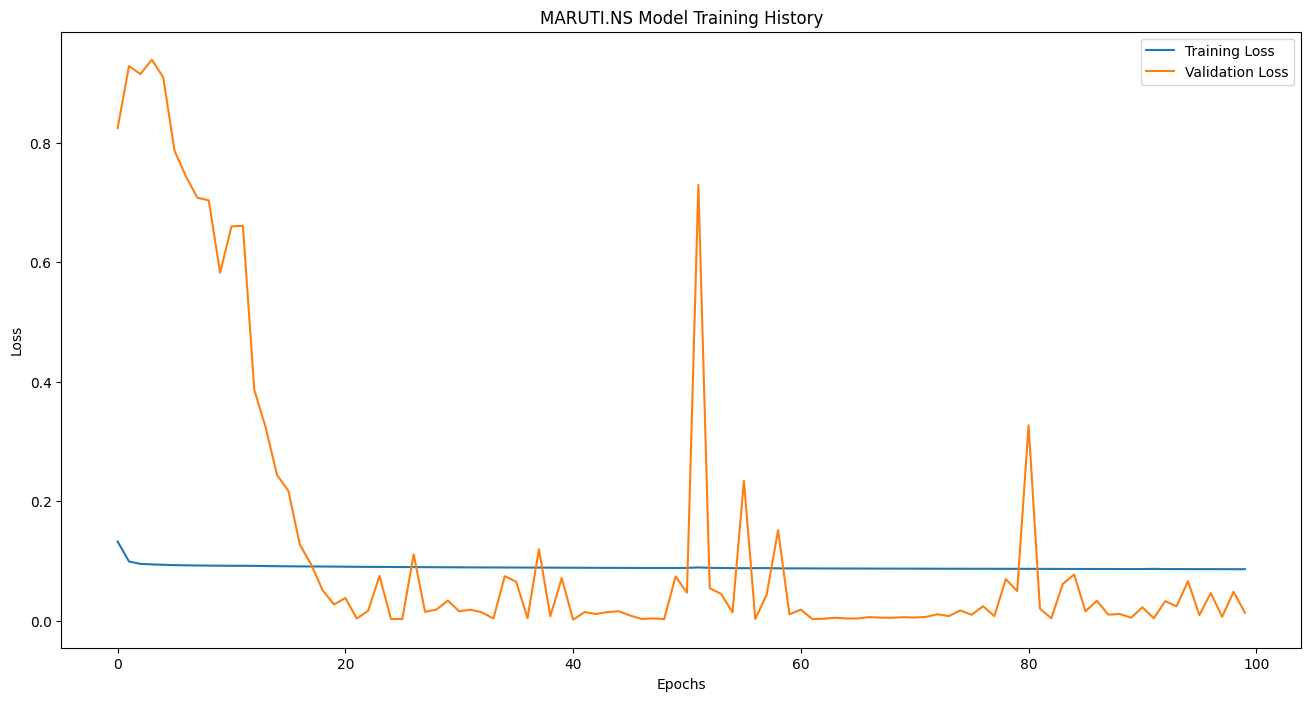

In [34]:
#plot training History (Loss Curve)
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from scipy.signal import argrelextrema
def predict_future(model, last_sequence, scaler, n_steps=1):
    """
    Predict future stock prices based on the last known sequence of data.

    Parameters:
    - model: Trained model
    - last_sequence: Last sequence of data (for example, the most recent sequence from the test set)
    - scaler: MinMaxScaler used for scaling the data
    - n_steps: Number of future steps to predict

    Returns:
    - future_predictions: Predicted future stock prices
    """
    # Reshape the last sequence to match model input
    last_sequence_reshaped = last_sequence.reshape((1, last_sequence.shape[0], last_sequence.shape[1]))

    # Predict future steps
    future_predictions = []
    current_input = last_sequence_reshaped

    for _ in range(n_steps):
        predicted_price = model.predict(current_input)[0, 0]
        future_predictions.append(predicted_price)

        # Update input sequence by adding the predicted price
        current_input = np.roll(current_input, -1, axis=1)
        current_input[0, -1, 0] = predicted_price

    # Inverse transform the predictions
    future_predictions = scaler.inverse_transform(
        np.hstack((np.array(future_predictions).reshape(-1, 1), np.zeros((len(future_predictions), 6))))
    )[:, 0]

    return future_predictions

def find_optimal_buy_points(prices, window=3, threshold=0.01):
    """
    Identify optimal buying points in a time series of prices.
    
    Parameters:
    - prices: Array of price values
    - window: Window size for local minima detection
    - threshold: Minimum difference between surrounding prices to be considered a local minimum
    
    Returns:
    - buy_indices: Indices of optimal buying points
    - buy_signals: Dictionary with buying signals and reasons
    """
    buy_indices = []
    buy_signals = {"points": [], "reasons": []}
    
    # Need at least 2*window+1 points for meaningful analysis
    if len(prices) < 2*window+1:
        return buy_indices, buy_signals
    
    # Find local minima (potential buying points)
    for i in range(window, len(prices)-window):
        # Check if current point is a local minimum
        window_slice = prices[i-window:i+window+1]
        if prices[i] == min(window_slice):
            # Allow some threshold difference between surrounding points
            before_diff = prices[i] - min(prices[i-window:i])
            after_diff = prices[i] - min(prices[i+1:i+window+1])
            if before_diff > threshold and after_diff > threshold:
                buy_indices.append(i)
                buy_signals["points"].append(prices[i])
                buy_signals["reasons"].append("Local minimum with significant change before and after")

    # If no signals found using the algorithm, find the absolute minimum
    if not buy_indices and len(prices) > 0:
        min_idx = np.argmin(prices)
        buy_indices.append(min_idx)
        buy_signals["points"].append(prices[min_idx])
        buy_signals["reasons"].append("Lowest price point")
    
    return buy_indices, buy_signals

def plot_with_future_predictions(train, valid, model, X_test, scaler, user_input_date):
    """
    Plot historical data along with future predictions and optimal buying points

    Parameters:
    - train: Training data DataFrame with 'Close' prices
    - valid: Validation data DataFrame with 'Close' and 'Predictions' columns
    - model: Trained model
    - X_test: Test feature data
    - scaler: MinMaxScaler used for scaling the data
    - future_days: Number of days to predict into the future
    
    Returns:
    - future_dates: Dates for future predictions
    - future_prices: Predicted future prices
    - buy_indices: Indices of optimal buying points
    - buy_signals: Dictionary with buying signals and reasons
    """
    if user_input_date:
        try:
            # Convert user input date to datetime
            future_start_date = datetime.strptime(user_input_date, '%Y-%m-%d')
        except ValueError:
            raise ValueError("Invalid date format. Please use 'YYYY-MM-DD'.")
    else:
        # If no date is provided, use the current date
        future_start_date = datetime.today()

    # Get the last sequence from the test set
    last_sequence = X_test[-1]
    
    # Get the end date as the last date from the validation set
    last_date = valid.index[-1]

    # Calculate the number of days between the last date (start) and user input date (end)
    future_days = (future_start_date - last_date).days

    if future_days <= 0:
        raise ValueError("The prediction date must be in the future. Please provide a valid future date.")

    # Predict future prices
    future_prices = predict_future(model, last_sequence, scaler, n_steps=future_days)

    # Create future dates (business days)
    last_date = valid.index[-1]
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=future_days, freq='B')
    
    # Find optimal buying points in future predictions
    buy_indices, buy_signals = find_optimal_buy_points(future_prices)

    # Create figure
    fig = go.Figure()

    # Add traces for historical data
    fig.add_trace(go.Scatter(x=train.index, y=train['Close'], 
                             mode='lines', name='Train Data',
                             fill='tozeroy',
                             fillgradient=dict(type='vertical',
                                               colorscale=[[0, 'rgba(74,143,223,0.1)'],
                                                           [1, 'rgba(76,148,223,0.8)']]),
                             line=dict(color='rgba(74,143,223,255)')))

    fig.add_trace(go.Scatter(x=valid.index, y=valid['Close'], 
                             mode='lines', name='Actual Price',
                             fill='tozeroy',
                             fillgradient=dict(type='vertical',
                                               colorscale=[[0, 'rgba(0,255,0,0.1)'],
                                                           [1, 'rgba(0,255,0,0.8)']]), 
                             line=dict(color='green')))

    fig.add_trace(go.Scatter(x=valid.index, y=valid['Predictions'],
                             fill='tozeroy',
                             fillgradient=dict(type='vertical',
                                               colorscale=[[0, 'rgba(255,0,0,0.1)'],
                                                           [1, 'rgba(255,0,0,0.8)']]),
                             mode='lines', name='Predicted Price', 
                             line=dict(color='red')))

    # Add trace for future predictions
    fig.add_trace(go.Scatter(x=future_dates, y=future_prices,
                             fill='tozeroy',
                             fillgradient=dict(type='vertical',
                                               colorscale=[[0, 'rgba(255,165,0,0.1)'],
                                                           [1, 'rgba(255,165,0,0.8)']]),
                             mode='lines', name='Future Predictions', 
                             line=dict(color='orange', dash='dash')))

    # Add markers for future predictions
    fig.add_trace(go.Scatter(x=future_dates, y=future_prices,
                             mode='markers', name='Future Points',
                             marker=dict(color='orange', size=8)))
    print(f"Buy Indices: {buy_indices}")
    
    # Add buy signals to the plot
    if buy_indices:
        buy_dates = [future_dates[i] for i in buy_indices]
        buy_prices = [future_prices[i] for i in buy_indices]
        
        fig.add_trace(go.Scatter(x=buy_dates, y=buy_prices,
                                mode='markers', name='Buy Signals',
                                marker=dict(color='cyan', size=12, symbol='star', line=dict(width=2, color='black')),
                                hovertemplate='<b>Buy Signal</b><br>Date: %{x}<br>Price: ₹%{y:,.2f}<br>Reason: %{text}<extra></extra>',
                                text=buy_signals["reasons"]))

    # Update layout
    fig.update_layout(title='Stock Price Prediction with Future Forecast & Buy Signals',
                      xaxis_title='Date',
                      yaxis_title='Stock Price',
                      width=900,
                      legend=dict(x=0, y=1),
                      plot_bgcolor='rgba(19,27,43,0.0)',
                      paper_bgcolor='rgba(19,27,43,0.0)',
                      font=dict(color='rgba(105,123,147,255)'),
                      hovermode="closest",
                      yaxis=dict(spikecolor="rgba(105,123,149,255)",
                                 spikedash="solid",
                                 spikethickness=-2,
                                 tickformat=',',
                                 tickprefix='₹',
                                 gridcolor="rgba(105,123,147,0.4)",
                                 zeroline=False),
                      xaxis=dict(spikecolor="rgba(105,123,147,255)",
                                 spikedash="solid",
                                 spikethickness=-2,
                                 gridcolor="rgba(105,123,147,0.4)",
                                 ))

    fig.update_xaxes(showline=False, linewidth=0, linecolor='rgba(105,123,147,255)')

    # Add annotations for buy signals
    for i, idx in enumerate(buy_indices):
        fig.add_annotation(
            x=future_dates[idx],
            y=future_prices[idx],
            text="BUY",
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="cyan",
            ax=0,
            ay=-40,
            font=dict(size=12, color="cyan"),
            bordercolor="black",
            borderwidth=1,
            borderpad=4,
            bgcolor="rgba(0,0,0,0.6)",
            opacity=0.8
        )

    # Show plot
    fig.show()

    return future_dates, future_prices, buy_indices, buy_signals

In [ ]:
from datetime import datetime, timedelta
future_dates, future_prices, buy_indices, buy_signals = plot_with_future_predictions(
    train, valid, model, X_test, scaler, user_input_date=input("Enter a date in YYYY-MM-DD format atleast 6 days from current date: ")
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Buy Indices: [7]


In [ ]:
from nnsvg import Architecture

# Left Model: Historical Price Data
left_model = Architecture(
    name="LSTM Model Using Only Historical Price Data",
    layers=[
        {"type": "input", "label": "Input (20x5)"},
        {"type": "lstm", "units": 128, "label": "LSTM (128, return_sequences=True)"},
        {"type": "lstm", "units": 64, "label": "LSTM (64)"},
        {"type": "dense", "units": 39, "label": "Dense (39)"},
        {"type": "batchnorm", "label": "BatchNorm"},
        {"type": "dense", "units": 1, "label": "Dense (1, Output)"}
    ]
)

# Right Model: Price + Sentiment Data
right_model = Architecture(
    name="LSTM Model Using Both Price and Sentiment Data",
    layers=[
        {"type": "input", "label": "Input (20x6)"},
        {"type": "lstm", "units": 130, "label": "LSTM (130, return_sequences=True)"},
        {"type": "lstm", "units": 69, "label": "LSTM (69, L1 regularized)"},
        {"type": "dense", "units": 63, "label": "Dense (63)"},
        {"type": "batchnorm", "label": "BatchNorm"},
        {"type": "dense", "units": 1, "label": "Dense (1, Output)"}
    ]
)

# Generate SVG for Left Model
left_svg = left_model.to_svg()
with open("left_model.svg", "w") as f:
    f.write(left_svg)

# Generate SVG for Right Model
right_svg = right_model.to_svg()
with open("right_model.svg", "w") as f:
    f.write(right_svg)

print("SVG diagrams generated: left_model.svg and right_model.svg")

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


Visualizing Left Model: Historical Price Data
Visualizing Right Model: Price + Sentiment Data
